<a href="https://colab.research.google.com/github/monisarker2/cse_327_project/blob/master/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Mount Google Drive in Colab

In [1]:
from google.colab import drive
drive.flush_and_unmount()  # Unmount first to avoid errors
drive.mount('/content/drive', force_remount=True)


Drive not mounted, so nothing to flush and unmount.
Mounted at /content/drive


Create Dataset Folders and Placeholder Images

In [2]:
import os
from PIL import Image
import numpy as np

# Define dataset path
dataset_path = "/content/drive/MyDrive/stop_sign_data"

# Define dataset split folders
splits = {
    "train": 18,  # 70% = 18 images per class
    "test": 5,    # 20% = 5 images per class
    "validation": 2  # 10% = 2 images per class
}

# Create the dataset folders
for split, count in splits.items():
    for category in ["stop_sign", "no_stop_sign"]:
        folder = f"{dataset_path}/{split}/{category}"
        os.makedirs(folder, exist_ok=True)

        # Create placeholder images (You can replace them later)
        for i in range(1, count + 1):
            img_path = f"{folder}/{category.replace('_sign', '')}{i}.jpg"

            # If the image doesn't exist, create a dummy one
            if not os.path.exists(img_path):
                img = Image.fromarray(np.random.randint(0, 255, (100, 100, 3), dtype=np.uint8))
                img.save(img_path)

print("✅ All dataset folders and placeholder images have been created successfully!")


✅ All dataset folders and placeholder images have been created successfully!


Verify That Folders and Images Exist

In [3]:
# Function to list files in each folder
def list_files(folder):
    return os.listdir(folder) if os.path.exists(folder) else "❌ Folder Not Found"

# Check all folders
print("Train Stop Sign Images:", list_files(f"{dataset_path}/train/stop_sign"))
print("Train No Stop Sign Images:", list_files(f"{dataset_path}/train/no_stop_sign"))
print("Test Stop Sign Images:", list_files(f"{dataset_path}/test/stop_sign"))
print("Test No Stop Sign Images:", list_files(f"{dataset_path}/test/no_stop_sign"))
print("Validation Stop Sign Images:", list_files(f"{dataset_path}/validation/stop_sign"))
print("Validation No Stop Sign Images:", list_files(f"{dataset_path}/validation/no_stop_sign"))


Train Stop Sign Images: ['stop2.jpg', 'stop10.jpg', 'stop9.jpg', 'stop3.jpg', 'stop12.jpg', 'stop8.jpg', 'stop17.jpg', 'stop15.jpg', 'stop4.jpg', 'stop5.jpg', 'stop11.jpg', 'stop6.jpg', 'stop1.jpg', 'stop7.jpg', 'stop18.jpg', 'stop16.jpg', 'stop14.jpg', 'stop13.jpg']
Train No Stop Sign Images: ['no_stop11.jpg', 'no_stop5.jpg', 'no_stop18.jpg', 'no_stop17.jpg', 'no_stop6.jpg', 'no_stop16.jpg', 'no_stop12.jpg', 'no_stop8.jpg', 'no_stop7.jpg', 'no_stop1.jpg', 'no_stop3.jpg', 'no_stop2.jpg', 'no_stop4.jpg', 'no_stop14.jpg', 'no_stop15.jpg', 'no_stop13.jpg', 'no_stop10.jpg', 'no_stop9.jpg']
Test Stop Sign Images: ['stop1.jpg', 'stop2.jpg', 'stop3.jpg', 'stop4.jpg', 'stop5.jpg']
Test No Stop Sign Images: ['no_stop1.jpg', 'no_stop2.jpg', 'no_stop3.jpg', 'no_stop4.jpg', 'no_stop5.jpg']
Validation Stop Sign Images: ['stop1.jpg', 'stop2.jpg']
Validation No Stop Sign Images: ['no_stop1.jpg', 'no_stop2.jpg']


Import Required Libraries

In [4]:
import os
import numpy as np
import cv2  # OpenCV for image processing
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC  # Using Support Vector Machine
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from google.colab.patches import cv2_imshow

Define Paths for Dataset

In [5]:
# Define dataset paths
dataset_path = "/content/drive/MyDrive/stop_sign_data"

# Set paths for each dataset split
train_path = os.path.join(dataset_path, "train")
test_path = os.path.join(dataset_path, "test")
val_path = os.path.join(dataset_path, "validation")

# Define categories
categories = ["stop_sign", "no_stop_sign"]


Load Images & Convert to Features

In [6]:
def load_images_from_folder(folder):
    images = []
    labels = []

    for category in categories:
        category_path = os.path.join(folder, category)

        # Check if category folder exists
        if not os.path.exists(category_path):
            print(f"❌ Folder not found: {category_path}")
            continue

        for img_name in os.listdir(category_path):
            img_path = os.path.join(category_path, img_name)

            # Read the image using OpenCV
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
            img = cv2.resize(img, (64, 64))  # Resize to 64x64

            images.append(img)
            labels.append(category)

    return np.array(images), np.array(labels)

# Load training data
X_train, y_train = load_images_from_folder(train_path)

# Load testing data
X_test, y_test = load_images_from_folder(test_path)

# Load validation data
X_val, y_val = load_images_from_folder(val_path)

print("✅ Dataset successfully loaded!")


✅ Dataset successfully loaded!


 Preprocess Data for Model


In [7]:
# Flatten images to 1D vectors
X_train = X_train.reshape(len(X_train), -1)
X_test = X_test.reshape(len(X_test), -1)
X_val = X_val.reshape(len(X_val), -1)

# Encode labels (stop_sign = 0, no_stop_sign = 1)
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
y_val = label_encoder.transform(y_val)

print(f"✅ Train set shape: {X_train.shape}, Labels: {y_train.shape}")
print(f"✅ Test set shape: {X_test.shape}, Labels: {y_test.shape}")
print(f"✅ Validation set shape: {X_val.shape}, Labels: {y_val.shape}")


✅ Train set shape: (36, 4096), Labels: (36,)
✅ Test set shape: (10, 4096), Labels: (10,)
✅ Validation set shape: (4, 4096), Labels: (4,)


 Train an SVM Model

In [8]:
# Train SVM classifier
svm_model = SVC(kernel="linear", probability=True)  # Linear Kernel for simplicity
svm_model.fit(X_train, y_train)

print("✅ SVM Model successfully trained!")


✅ SVM Model successfully trained!


 Evaluate the Model

In [10]:
# Predictions on train data
y_pred_train = svm_model.predict(X_train)
train_accuracy = accuracy_score(y_train, y_pred_train)
print(f"📌 Train Accuracy: {train_accuracy:.2f}")

# Predictions on test data
y_pred_test = svm_model.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred_test)
print(f"📌 Test Accuracy: {test_accuracy:.2f}")

# Predictions on validation data
y_pred_val = svm_model.predict(X_val)
val_accuracy = accuracy_score(y_val, y_pred_val)
print(f"📌 Validation Accuracy: {val_accuracy:.2f}")

# Print detailed classification report for train data
print("\n🔍 Classification Report (Train Data):")
print(classification_report(y_train, y_pred_train, target_names=categories))

# Print detailed classification report for test data
print("\n🔍 Classification Report (Test Data):")
print(classification_report(y_test, y_pred_test, target_names=categories))

# Print detailed classification report for validation data
print("\n🔍 Classification Report (Validation Data):")
print(classification_report(y_val, y_pred_val, target_names=categories))


📌 Train Accuracy: 1.00
📌 Test Accuracy: 0.80
📌 Validation Accuracy: 0.50

🔍 Classification Report (Train Data):
              precision    recall  f1-score   support

   stop_sign       1.00      1.00      1.00        18
no_stop_sign       1.00      1.00      1.00        18

    accuracy                           1.00        36
   macro avg       1.00      1.00      1.00        36
weighted avg       1.00      1.00      1.00        36


🔍 Classification Report (Test Data):
              precision    recall  f1-score   support

   stop_sign       0.71      1.00      0.83         5
no_stop_sign       1.00      0.60      0.75         5

    accuracy                           0.80        10
   macro avg       0.86      0.80      0.79        10
weighted avg       0.86      0.80      0.79        10


🔍 Classification Report (Validation Data):
              precision    recall  f1-score   support

   stop_sign       0.50      1.00      0.67         2
no_stop_sign       0.00      0.00      0.00

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Predict on a New Image

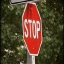

🛑 Prediction: stop_sign


In [ ]:
def predict_image(image_path):
    # Read and process the image
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    img = cv2.resize(img, (64, 64))
    img = img.reshape(1, -1)  # Flatten

    # Predict
    prediction = svm_model.predict(img)
    label = label_encoder.inverse_transform(prediction)[0]

    # Display image
    cv2_imshow(cv2.imread(image_path))  # Display image in Google Colab
    print(f"🛑 Prediction: {label}")

# Test with a new image
test_image_path = "/content/drive/MyDrive/stop_sign_data/test/stop_sign/stop1.jpg"  # Change as needed
predict_image(test_image_path)
